In [1]:
import pickle, re, sys

In [2]:
import matplotlib.pyplot as plt
import matplotlib

In [3]:
import logging
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING) 

In [4]:
import ssm_pca, ssm_tools, ssm_atlas

In [5]:
%qtconsole

In [16]:
import importlib

<module 'ssm_pca' from '/home/face3d/Documents/SSM_matlab_github/python/ssm_pca.py'>

# TOF aortas -- Endrit

In [5]:
base_dir = "/home/face3d/Desktop/SSM - visualisation demo/Aorta -- Endrit/"
list_id = [l.strip() for l in open(base_dir + "list.txt", "r")]

Pré-processing

Atlas estimation

In [6]:
ae = ssm_atlas.DeformetricaAtlasEstimation(
        idir=base_dir + "TOF/",
        odir=base_dir + "out/",
        name="aorta",
        initial_guess=0,
        kwd=25.,
        kwg=15.,
        noise=10.)

In [7]:
print(ae.initial_guess)

/home/face3d/Desktop/SSM - visualisation demo/Aorta -- Endrit/TOF/TOFPR-3-1-segmentation_ext.vtk


In [17]:
ae.estimate()

Logger has been set to: DEBUG
>> No initial CP spacing given: using diffeo kernel width of 25.0
OMP_NUM_THREADS found in environment variables. Using value OMP_NUM_THREADS=4
context has already been set
>> No specified state-file. By default, Deformetrica state will by saved in file: /home/face3d/Desktop/SSM - visualisation demo/Aorta -- Endrit/out/output/deformetrica-state.p.
>> Using a Sobolev gradient for the template data with the ScipyLBFGS estimator memory length being larger than 1. Beware: that can be tricky.
{'memory_length': 10, 'freeze_template': False, 'max_line_search_iterations': 10, 'optimized_log_likelihood': 'complete', 'optimization_method_type': 'scipylbfgs', 'max_iterations': 50, 'convergence_tolerance': 0.001, 'print_every_n_iters': 1, 'save_every_n_iters': 100, 'gpu_mode': <GpuMode.KERNEL: 4>, 'state_file': '/home/face3d/Desktop/SSM - visualisation demo/Aorta -- Endrit/out/output/deformetrica-state.p', 'load_state_file': False}
/home/face3d/Desktop/SSM - visualisa

>> Number of line search loops exceeded. Stopping.
>> Estimation took: 10 minutes and 55 seconds
Deformetrica.__del__()
Deformetrica.__del__()


Results

subjects, control_points, dim: (5, 24, 3)


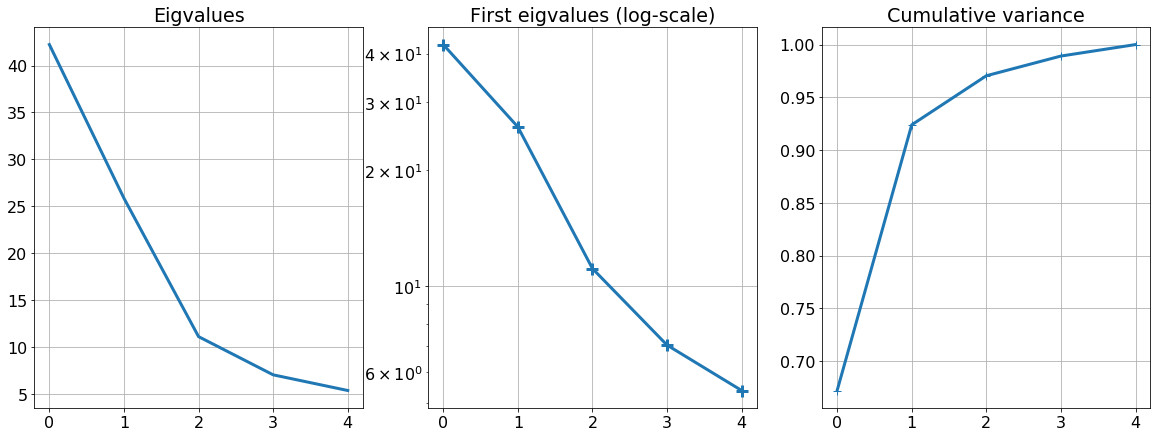

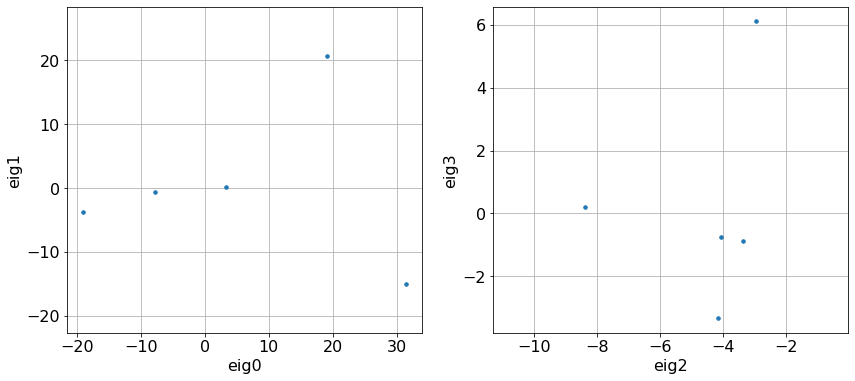

In [18]:
ao = ssm_pca.DeformetricaAtlasPCA(
    idir = ae.odir + "output/",
    odir = ae.odir + "pca/")
ao.compute_pca(with_plots=True)
f0 = ao.save_eigv(0, with_controlpoints=True)
f1 = ao.save_eigv(1, with_controlpoints=True)

In [19]:
ae.shooting(f0, ae.odir + "pca/shoot0/")
ae.shooting(f1, ae.odir + "pca/shoot1/")

Logger has been set to: INFO
OMP_NUM_THREADS was not found in environment variables. An automatic value will be set.
OMP_NUM_THREADS will be set to 4
context has already been set
[ compute_shooting function ]
/home/face3d/Desktop/SSM - visualisation demo/Aorta -- Endrit/out/output/DeterministicAtlas__EstimatedParameters__Template_aorta.vtk 3
(5000, 3) (9900, 3)
Renaming files for paraview
  regex:  /home/face3d/Desktop/SSM - visualisation demo/Aorta -- Endrit/out/pca/shoot0/Shooting__GeodesicFlow__aorta__tp_*__age_*.vtk
  nb of files:  101
Logger has been set to: INFO
OMP_NUM_THREADS was not found in environment variables. An automatic value will be set.
OMP_NUM_THREADS will be set to 4
context has already been set
[ compute_shooting function ]
/home/face3d/Desktop/SSM - visualisation demo/Aorta -- Endrit/out/output/DeterministicAtlas__EstimatedParameters__Template_aorta.vtk 3
(5000, 3) (9900, 3)
Renaming files for paraview
  regex:  /home/face3d/Desktop/SSM - visualisation demo/Aorta 

### warping mesh to template

see /home/face3d/Desktop/SSM - visualisation demo/Aortic roots -- Claudio/warping_calcium.py

In [8]:
fmmt, fctp = ae.momenta_from_sbj_to_atlas(0, ae.odir + "sbj{}/".format(0), do_warpback=True)

Logger has been set to: INFO
OMP_NUM_THREADS was not found in environment variables. An automatic value will be set.
OMP_NUM_THREADS will be set to 4
[ compute_shooting function ]
/home/face3d/Desktop/SSM - visualisation demo/Aorta -- Endrit/out/output/DeterministicAtlas__EstimatedParameters__Template_aorta.vtk 3
(5000, 3) (9900, 3)
Defaulting geodesic t0 to 1.


/home/face3d/anaconda3/envs/py36/lib/python3.7/site-packages/in_out/dataset_functions.py:265: UserWarning: Watch out, I did not get a distance type for the object aorta, Please make sure you are running shooting or a parallel transport, otherwise distances are required.
  warnings.warn(msg)


### warping volumetric meshes
(using the subject-to-template deformation)

In [10]:
import volumetric_meshes

In [17]:
importlib.reload(volumetric_meshes)

<module 'volumetric_meshes' from '/home/face3d/Documents/SSM_matlab_github/python/volumetric_meshes.py'>

In [13]:
fn = ae.get_path_data(0)[:-7] + "cfd.vtu"
print(os.path.exists(fn), fn)

odir = ae.odir + "sbj0/vtu/"

True /home/face3d/Desktop/SSM - visualisation demo/Aorta -- Endrit/TOF/TOFPR-3-1-segmentation_cfd.vtu


In [18]:
volumetric_meshes.shoot_vtu(fin=fn, fvtk=odir+"points.vtk", 
                          fmoments=fmmt, fctrlpts=fctp, 
                          odir=odir, fout=odir+"vol_mesh.vtu", 
                          kw=ae.p_kernel_width_deformation, noise=ae.p_noise, name=ae.id)

Logger has been set to: INFO
OMP_NUM_THREADS found in environment variables. Using value OMP_NUM_THREADS=4
context has already been set
[ compute_shooting function ]
Defaulting geodesic t0 to 1.


### warping a mesh back to atlas
similar to do_warpback option in ae.momenta_from_sbj_to_atlas

In [21]:
import deformetrica

In [22]:
template_specifications = {
                ae.id: {'deformable_object_type': 'surfacemesh',
                'noise_std': 0.,
                'filename': ae.get_path_data(0)}
            }
model_options={
                'dimension': 3,
                'deformation_kernel_type': 'torch',
                'deformation_kernel_width': ae.p_kernel_width_deformation,
                'tmin':0,
                'tmax':1,
                "initial_control_points": ae.odir + "sbj0/backward_ctrlpts.txt",
                "initial_momenta": ae.odir + "sbj0/backward_momenta.txt"}

Deformetrica = deformetrica.api.Deformetrica(verbosity="INFO", output_dir=ae.odir + "sbj0/backward/")
Deformetrica.compute_shooting(template_specifications, model_options=model_options)

Logger has been set to: INFO
OMP_NUM_THREADS was not found in environment variables. An automatic value will be set.
OMP_NUM_THREADS will be set to 4
context has already been set
[ compute_shooting function ]
/home/face3d/Desktop/SSM - visualisation demo/Aorta -- Endrit/TOF/TOFPR-3-1-segmentation_ext.vtk 3
(5000, 3) (9900, 3)
Defaulting geodesic t0 to 1.


/home/face3d/anaconda3/envs/py36/lib/python3.7/site-packages/in_out/dataset_functions.py:265: UserWarning: Watch out, I did not get a distance type for the object aorta, Please make sure you are running shooting or a parallel transport, otherwise distances are required.
  warnings.warn(msg)
